In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from pathlib import Path
import glob

# Set up matplotlib for better plots
# plt.style.use('default')
# plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"Available .mat files in data folder:")
for file in glob.glob("*.mat"):
    print(f"  - {file}")


Libraries imported successfully!
Available .mat files in data folder:
  - S2A_MSIL1C_20171028_T34HCH.mat
  - S2B_MSIL1C_20170725_T43WFQ.mat
  - S2B_MSIL1C_20171022_T49JGM.mat
  - S2A_MSIL1C_20170527_T33UUB.mat
  - S2B_MSIL1C_20170928_T18TWL.mat


In [2]:
def load_mat_file(filename):
    """
    Load .mat file using appropriate method (h5py for v7.3
    """
    try:
        # First try with h5py (for MATLAB v7.3 files)
        with h5py.File(filename, 'r') as f:
            print(f"Loading {filename} using h5py (MATLAB v7.3 format)")
            data_dict = {}
            
            def extract_datasets(name, obj):
                if isinstance(obj, h5py.Dataset):
                    # Load the dataset and transpose if needed (MATLAB vs Python array ordering)
                    data = obj[()]
                    if data.ndim > 1:
                        data = np.transpose(data)
                    data_dict[name] = data
            
            # Visit all datasets in the file
            f.visititems(extract_datasets)
            return data_dict
            
    except (OSError, KeyError, ImportError):
   
        print(f"Error loading {filename} with both methods: {e}")
        return None

# Load and explore the structure of a sample .mat file
sample_file = "S2A_MSIL1C_20170527_T33UUB.mat"

data= load_mat_file(sample_file)

if data is not None:
    print(f"Contents of {sample_file} ")
    print("-" * 60)
    
    # Display keys (variables) in the .mat file
    for key in data.keys():
        if not key.startswith('__'):  # Skip metadata keys
            print(f"Variable: {key}")
            print(f"  Type: {type(data[key])}")
            print(f"  Shape: {data[key].shape if hasattr(data[key], 'shape') else 'N/A'}")
            print(f"  Data type: {data[key].dtype if hasattr(data[key], 'dtype') else 'N/A'}")
            if hasattr(data[key], 'shape') and data[key].shape:
                print(f"  Min/Max: {np.min(data[key]):.2f} / {np.max(data[key]):.2f}")
            print()
else:
    print(f"Failed to load {sample_file}")
    print("Available files:")
    for file in glob.glob("*.mat"):
        print(f"  - {file}")


Loading S2A_MSIL1C_20170527_T33UUB.mat using h5py (MATLAB v7.3 format)
Contents of S2A_MSIL1C_20170527_T33UUB.mat 
------------------------------------------------------------
Variable: im10
  Type: <class 'numpy.ndarray'>
  Shape: (600, 600, 4)
  Data type: float32
  Min/Max: 271.00 / 5950.00

Variable: im20
  Type: <class 'numpy.ndarray'>
  Shape: (300, 300, 6)
  Data type: float32
  Min/Max: 35.00 / 13109.00

Variable: im60
  Type: <class 'numpy.ndarray'>
  Shape: (100, 100, 2)
  Data type: float32
  Min/Max: 67.00 / 1860.00



In [3]:
def normalize_band(band_data, percentile_clip=2):
    """Normalize band data for visualization"""
    # Remove any invalid values
    valid_data = band_data[~np.isnan(band_data) & ~np.isinf(band_data)]
    
    if len(valid_data) == 0:
        return band_data
    
    # Clip outliers using percentiles
    p_low = np.percentile(valid_data, percentile_clip)
    p_high = np.percentile(valid_data, 100 - percentile_clip)
    
    # Normalize to 0-1 range
    normalized = np.clip((band_data - p_low) / (p_high - p_low), 0, 1)
    return normalized

def visualize_sentinel_image(data, variable_name, filename):
    """Create comprehensive visualization of Sentinel-2 data"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Sentinel-2 Visualization: {filename}\nVariable: {variable_name}', fontsize=16, fontweight='bold')
    
    # If data has multiple bands (3D array)
    if len(data.shape) == 3:
        height, width, bands = data.shape
        
        # Plot 1: First band (grayscale)
        band1 = normalize_band(data[:, :, 0])
        im1 = axes[0, 0].imshow(band1, cmap='gray')
        axes[0, 0].set_title(f'Band 1 (Shape: {band1.shape})')
        axes[0, 0].axis('off')
        plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
        
        # Plot 2: RGB composite (if at least 3 bands)
        if bands >= 3:
            # Assume bands are in order (Red, Green, Blue) or create a suitable composite
            rgb = np.zeros((height, width, 3))
            rgb[:, :, 0] = normalize_band(data[:, :, min(2, bands-1)])  # Red
            rgb[:, :, 1] = normalize_band(data[:, :, min(1, bands-1)])  # Green  
            rgb[:, :, 2] = normalize_band(data[:, :, 0])                # Blue
            
            axes[0, 1].imshow(rgb)
            axes[0, 1].set_title('RGB Composite')
            axes[0, 1].axis('off')
        else:
            axes[0, 1].text(0.5, 0.5, 'Not enough bands\nfor RGB composite', 
                           ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].axis('off')
        
        # Plot 3: Last band
        if bands > 1:
            band_last = normalize_band(data[:, :, -1])
            im3 = axes[0, 2].imshow(band_last, cmap='viridis')
            axes[0, 2].set_title(f'Band {bands} (Shape: {band_last.shape})')
            axes[0, 2].axis('off')
            plt.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
        else:
            axes[0, 2].axis('off')
        
        # Plot 4: Statistics histogram
        axes[1, 0].hist(data.flatten(), bins=50, alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Pixel Value Distribution')
        axes[1, 0].set_xlabel('Pixel Value')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Band comparison (if multiple bands)
        if bands > 1:
            band_means = [np.nanmean(data[:, :, i]) for i in range(min(bands, 10))]
            band_stds = [np.nanstd(data[:, :, i]) for i in range(min(bands, 10))]
            
            x_pos = range(len(band_means))
            axes[1, 1].bar(x_pos, band_means, yerr=band_stds, capsize=5, alpha=0.7)
            axes[1, 1].set_title('Band Statistics (Mean ± Std)')
            axes[1, 1].set_xlabel('Band Number')
            axes[1, 1].set_ylabel('Mean Value')
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].axis('off')
        
        # Plot 6: Data info
        info_text = f"""Data Information:
Shape: {data.shape}
Bands: {bands}
Data type: {data.dtype}
Min value: {np.nanmin(data):.2f}
Max value: {np.nanmax(data):.2f}
Mean value: {np.nanmean(data):.2f}
Std value: {np.nanstd(data):.2f}
Valid pixels: {np.sum(~np.isnan(data))}
NaN pixels: {np.sum(np.isnan(data))}"""
        
        axes[1, 2].text(0.05, 0.95, info_text, transform=axes[1, 2].transAxes, 
                        fontsize=10, verticalalignment='top', fontfamily='monospace')
        axes[1, 2].axis('off')
        
    # If data is 2D (single band)
    elif len(data.shape) == 2:
        # Plot single band with different colormaps
        band_norm = normalize_band(data)
        
        colormaps = ['gray', 'viridis', 'plasma', 'inferno']
        for i, cmap in enumerate(colormaps[:4]):
            row, col = i // 2, i % 2
            im = axes[row, col].imshow(band_norm, cmap=cmap)
            axes[row, col].set_title(f'Colormap: {cmap}')
            axes[row, col].axis('off')
            plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)
        
        # Statistics and info in remaining plots
        axes[1, 0].hist(data.flatten(), bins=50, alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Pixel Value Distribution')
        axes[1, 0].set_xlabel('Pixel Value')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)
        
        info_text = f"""Data Information:
Shape: {data.shape}
Data type: {data.dtype}
Min value: {np.nanmin(data):.2f}
Max value: {np.nanmax(data):.2f}
Mean value: {np.nanmean(data):.2f}
Std value: {np.nanstd(data):.2f}
Valid pixels: {np.sum(~np.isnan(data))}
NaN pixels: {np.sum(np.isnan(data))}"""
        
        axes[1, 1].text(0.05, 0.95, info_text, transform=axes[1, 1].transAxes, 
                        fontsize=10, verticalalignment='top', fontfamily='monospace')
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualization functions (normalize_band and visualize_sentinel_image) defined successfully!")


Visualization functions (normalize_band and visualize_sentinel_image) defined successfully!


In [4]:
def load_sentinel_data(filename):
    """Load Sentinel-2 data from .mat file (supports both v7.3 and older formats)"""
    try:
        data = load_mat_file(filename)
        if data is None:
            return None, None
            
        # Get the main data variable (usually the first non-metadata key)
        data_keys = [key for key in data.keys() if not key.startswith('__')]
        
        if data_keys:
            # Find the largest dataset (likely the main satellite image data)
            main_key = None
            max_size = 0
            
            for key in data_keys:
                if hasattr(data[key], 'size') and data[key].size > max_size:
                    max_size = data[key].size
                    main_key = key
            
            if main_key:
                main_data = data[main_key]
                print(f"Selected variable '{main_key}' as main data")
                print(f"Data shape: {main_data.shape}")
                print(f"Data type: {main_data.dtype}")
                
                # Handle different data structures
                if main_data.ndim == 2:
                    print("Data appears to be a 2D single-band image")
                elif main_data.ndim == 3:
                    print(f"Data appears to be a 3D multi-band image with {main_data.shape[2]} bands")
                else:
                    print(f"Data has {main_data.ndim} dimensions")
                
                return main_data, main_key
            else:
                print("No suitable data variable found")
                return None, None
        else:
            print("No data variables found in file")
            return None, None
            
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None, None

Loading S2A_MSIL1C_20170527_T33UUB.mat using h5py (MATLAB v7.3 format)
Selected variable 'im10' as main data
Data shape: (600, 600, 4)
Data type: float32
Data appears to be a 3D multi-band image with 4 bands
Successfully loaded data from S2A_MSIL1C_20170527_T33UUB.mat
Variable name: im10


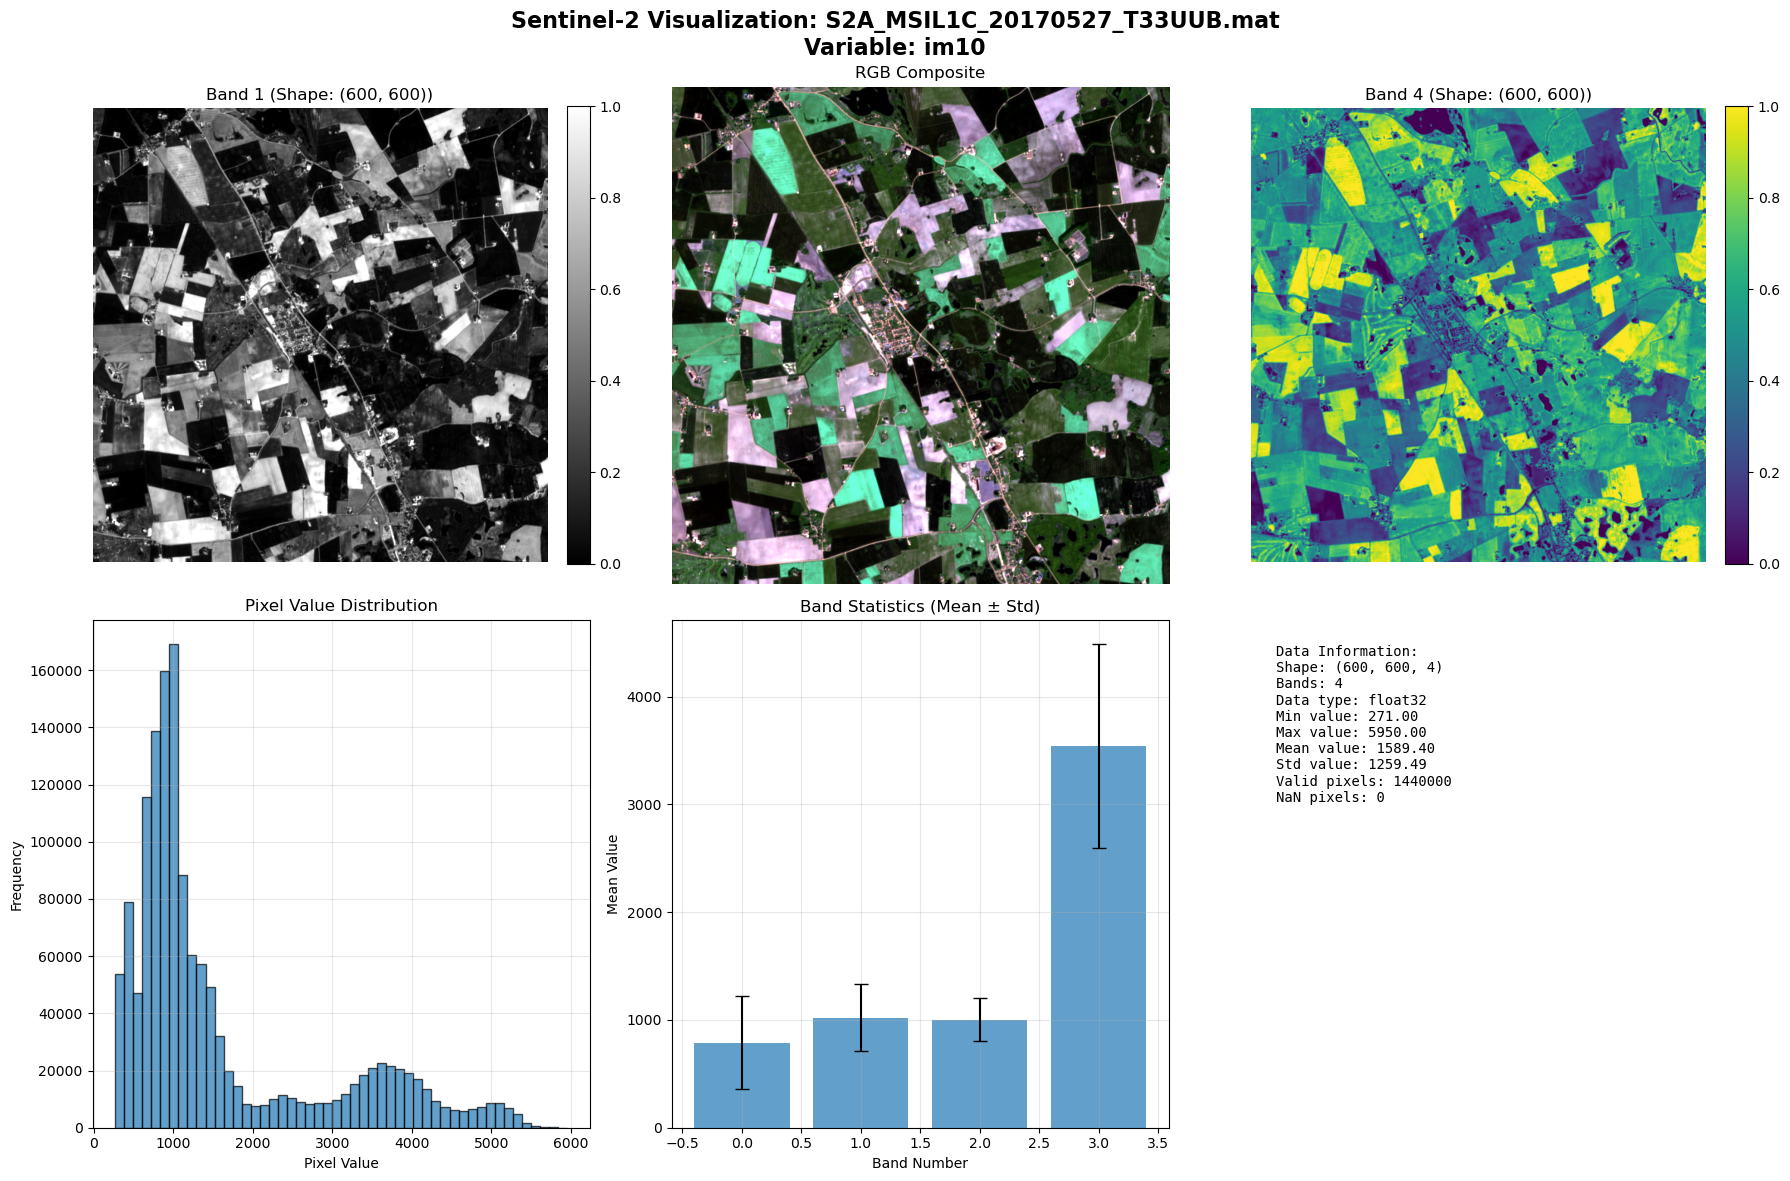

In [5]:
# Example: Visualize the first Sentinel-2 image
filename = "S2A_MSIL1C_20170527_T33UUB.mat"

# Load the data
data, variable_name = load_sentinel_data(filename)

if data is not None:
    print(f"Successfully loaded data from {filename}")
    print(f"Variable name: {variable_name}")
    
    # Create comprehensive visualization
    visualize_sentinel_image(data, variable_name, filename)
else:
    print("Failed to load data. Please check the file path and format.")


Found 5 .mat files:
  - S2A_MSIL1C_20171028_T34HCH.mat
  - S2B_MSIL1C_20170725_T43WFQ.mat
  - S2B_MSIL1C_20171022_T49JGM.mat
  - S2A_MSIL1C_20170527_T33UUB.mat
  - S2B_MSIL1C_20170928_T18TWL.mat

Comparing Sentinel-2 images...
Loading S2A_MSIL1C_20171028_T34HCH.mat...
Loading S2A_MSIL1C_20171028_T34HCH.mat using h5py (MATLAB v7.3 format)
Selected variable 'im10' as main data
Data shape: (600, 600, 4)
Data type: float32
Data appears to be a 3D multi-band image with 4 bands
Loading S2B_MSIL1C_20170725_T43WFQ.mat...
Loading S2B_MSIL1C_20170725_T43WFQ.mat using h5py (MATLAB v7.3 format)
Selected variable 'imGT' as main data
Data shape: (600, 600, 6)
Data type: float32
Data appears to be a 3D multi-band image with 6 bands
Loading S2B_MSIL1C_20171022_T49JGM.mat...
Loading S2B_MSIL1C_20171022_T49JGM.mat using h5py (MATLAB v7.3 format)
Selected variable 'im10' as main data
Data shape: (600, 600, 4)
Data type: float32
Data appears to be a 3D multi-band image with 4 bands


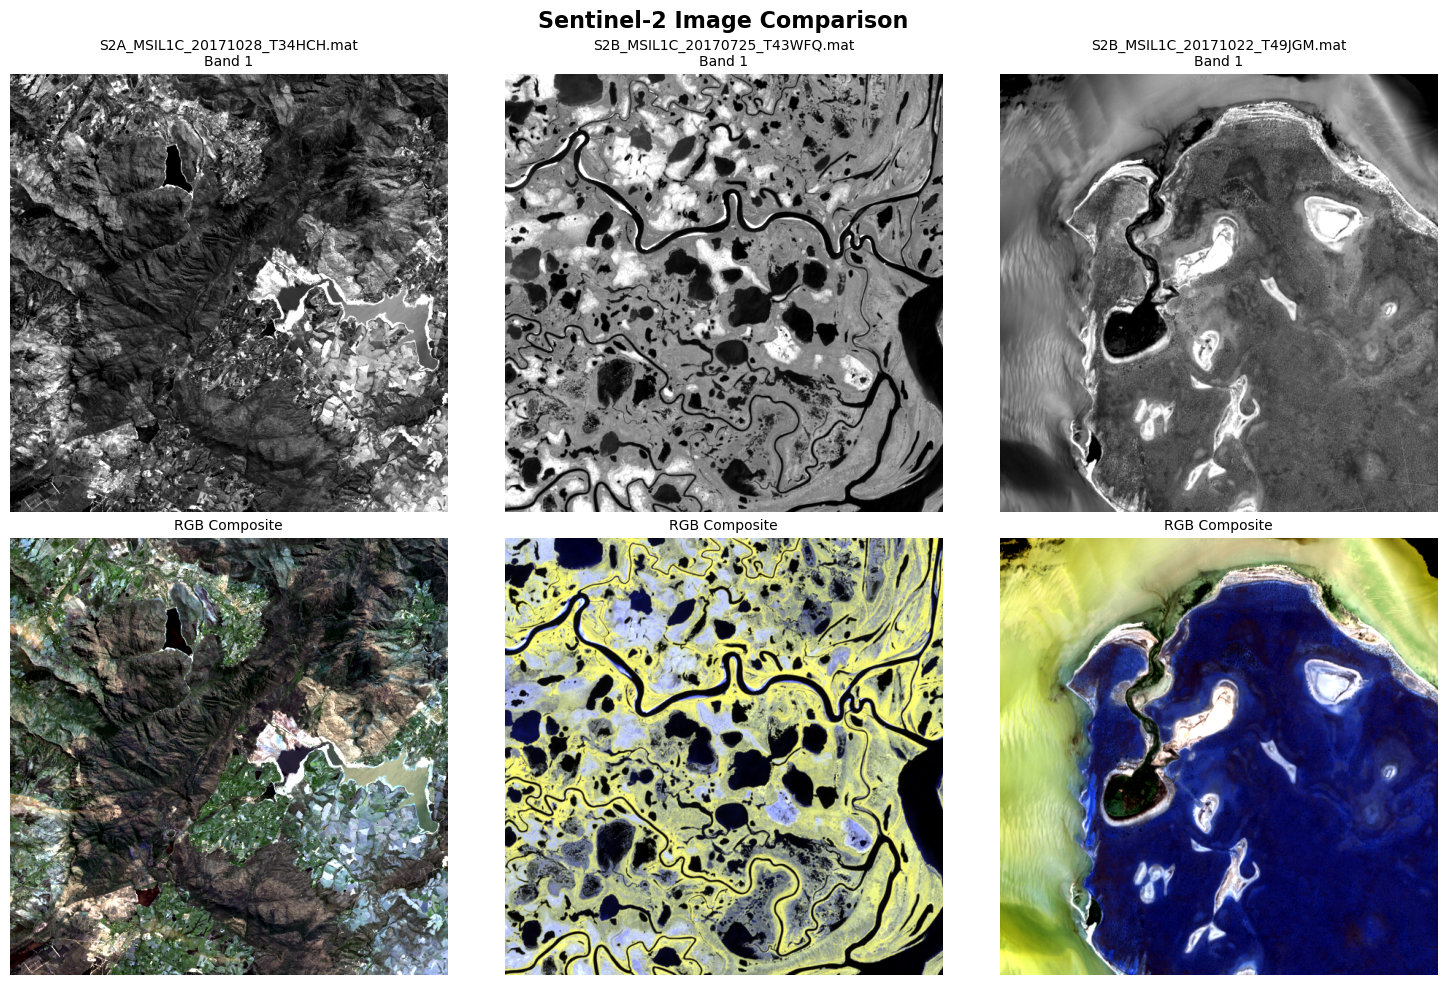

In [6]:
# Compare multiple Sentinel-2 images
def compare_sentinel_images(filenames, max_images=4):
    """Compare multiple Sentinel-2 images side by side"""
    
    n_files = min(len(filenames), max_images)
    fig, axes = plt.subplots(2, n_files, figsize=(5*n_files, 10))
    
    if n_files == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle('Sentinel-2 Image Comparison', fontsize=16, fontweight='bold')
    
    for i, filename in enumerate(filenames[:n_files]):
        print(f"Loading {filename}...")
        data, var_name = load_sentinel_data(filename)
        
        if data is not None:
            # Show first band
            if len(data.shape) >= 2:
                band_data = data[:, :, 0] if len(data.shape) == 3 else data
                normalized = normalize_band(band_data)
                
                im1 = axes[0, i].imshow(normalized, cmap='gray')
                axes[0, i].set_title(f'{filename}\nBand 1', fontsize=10)
                axes[0, i].axis('off')
                
                # Show RGB composite if available
                if len(data.shape) == 3 and data.shape[2] >= 3:
                    height, width, bands = data.shape
                    rgb = np.zeros((height, width, 3))
                    rgb[:, :, 0] = normalize_band(data[:, :, min(2, bands-1)])  # Red
                    rgb[:, :, 1] = normalize_band(data[:, :, min(1, bands-1)])  # Green  
                    rgb[:, :, 2] = normalize_band(data[:, :, 0])                # Blue
                    
                    axes[1, i].imshow(rgb)
                    axes[1, i].set_title('RGB Composite', fontsize=10)
                    axes[1, i].axis('off')
                else:
                    # Show the same band with different colormap
                    im2 = axes[1, i].imshow(normalized, cmap='viridis')
                    axes[1, i].set_title('Viridis Colormap', fontsize=10)
                    axes[1, i].axis('off')
        else:
            axes[0, i].text(0.5, 0.5, f'Failed to load\n{filename}', 
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get all .mat files
mat_files = glob.glob("*.mat")
print(f"Found {len(mat_files)} .mat files:")
for file in mat_files:
    print(f"  - {file}")

# Compare the first few images
if mat_files:
    print("\nComparing Sentinel-2 images...")
    compare_sentinel_images(mat_files, max_images=3)
else:
    print("No .mat files found in the current directory.")


Found 4 .npy files in train60:
  - train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data60_gt.npy
  - train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20.npy
  - train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data10.npy
  - train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data60.npy

Visualizing first 3 files...

File 1: train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data60_gt.npy
Loaded train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data60_gt.npy: shape (500, 2, 96, 96)


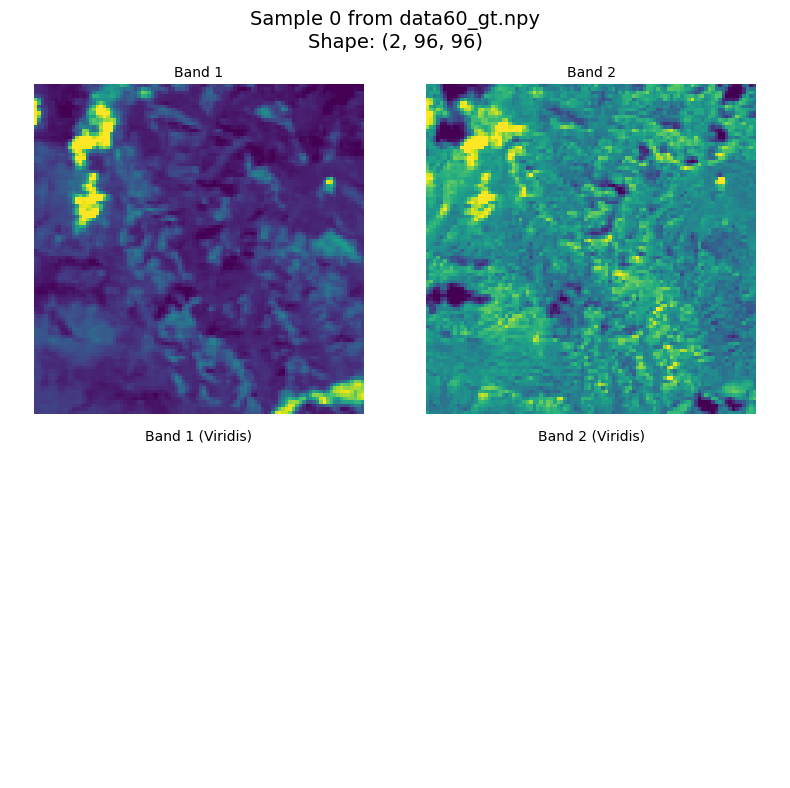


Statistics for sample 0:
Band 1: min=815.00, max=5536.00, mean=1172.88, std=280.27
Band 2: min=1127.00, max=7656.00, mean=2719.51, std=423.26

File 2: train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20.npy
Loaded train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20.npy: shape (500, 6, 96, 96)


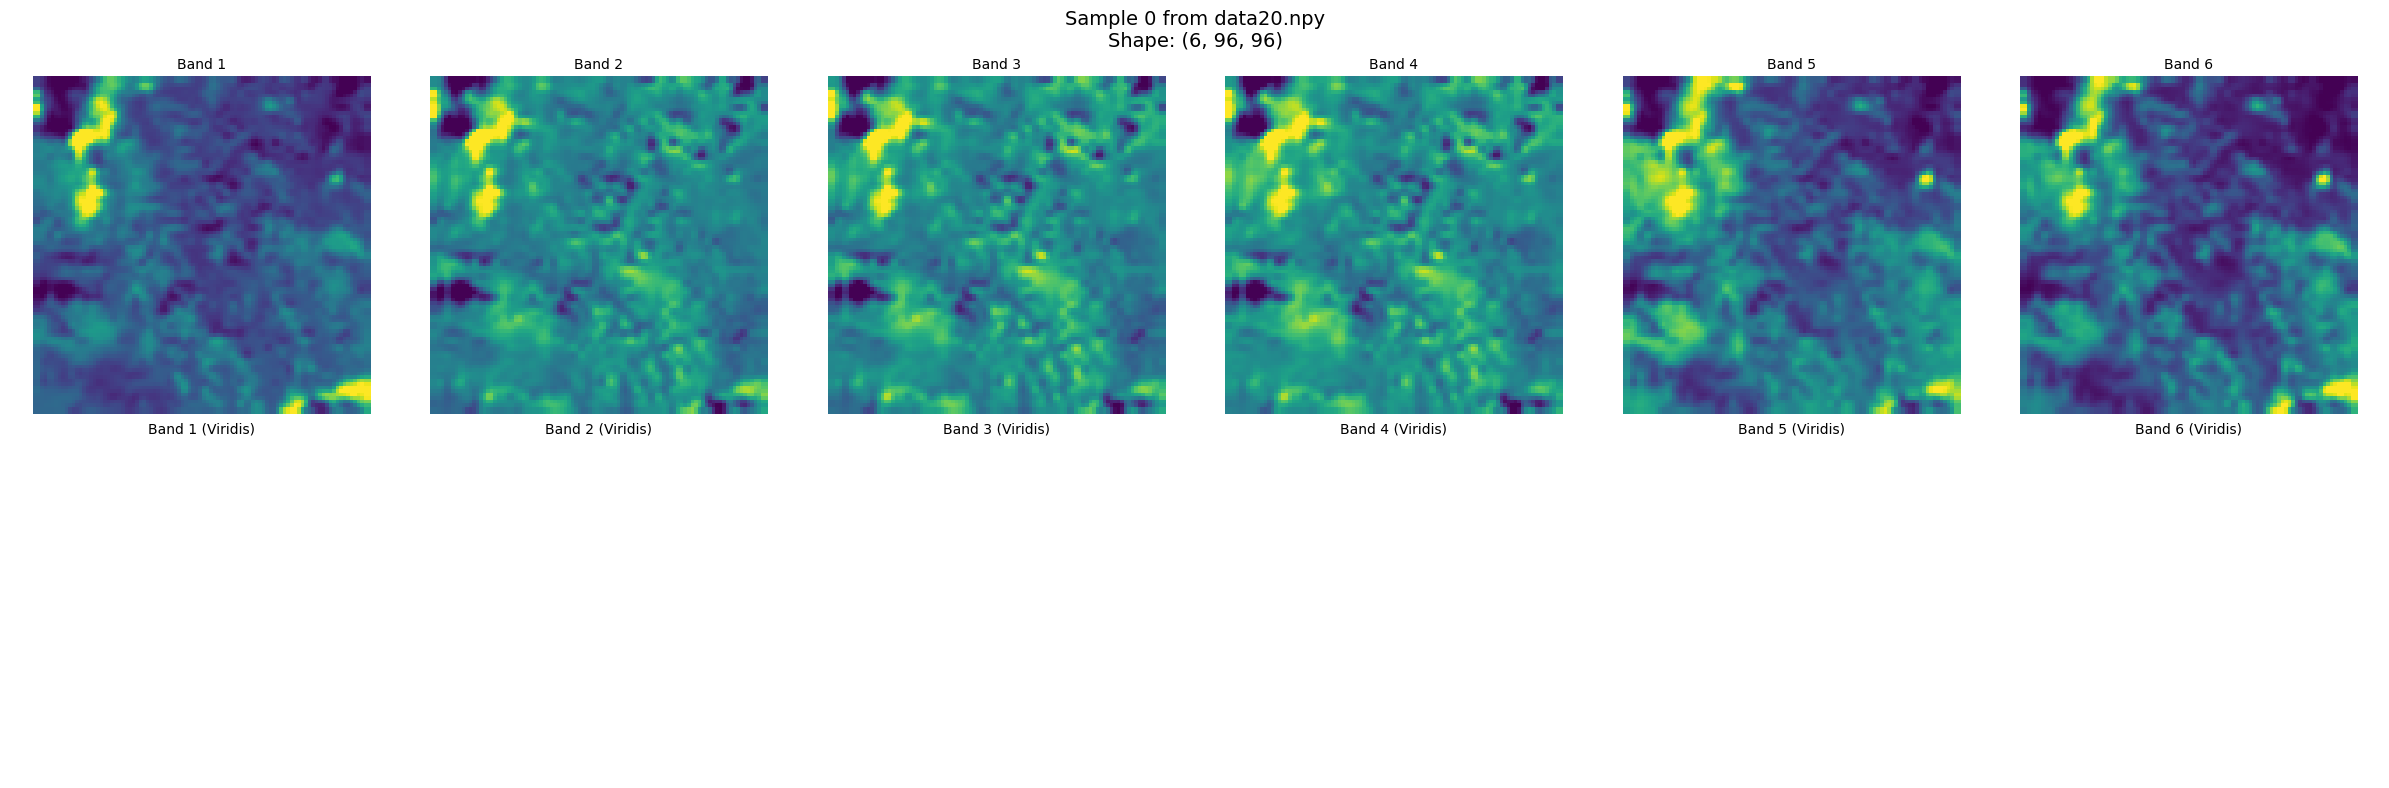


Statistics for sample 0:
Band 1: min=1024.66, max=4553.84, mean=1652.09, std=279.61
Band 2: min=1243.83, max=4884.24, mean=2285.84, std=255.11
Band 3: min=1293.52, max=4953.55, mean=2467.13, std=276.39
Band 4: min=1328.31, max=5047.79, mean=2646.53, std=300.90
Band 5: min=1136.22, max=4929.79, mean=2204.66, std=490.04
Band 6: min=1068.62, max=4688.73, mean=1803.21, std=416.38

File 3: train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data10.npy
Loaded train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data10.npy: shape (500, 4, 96, 96)


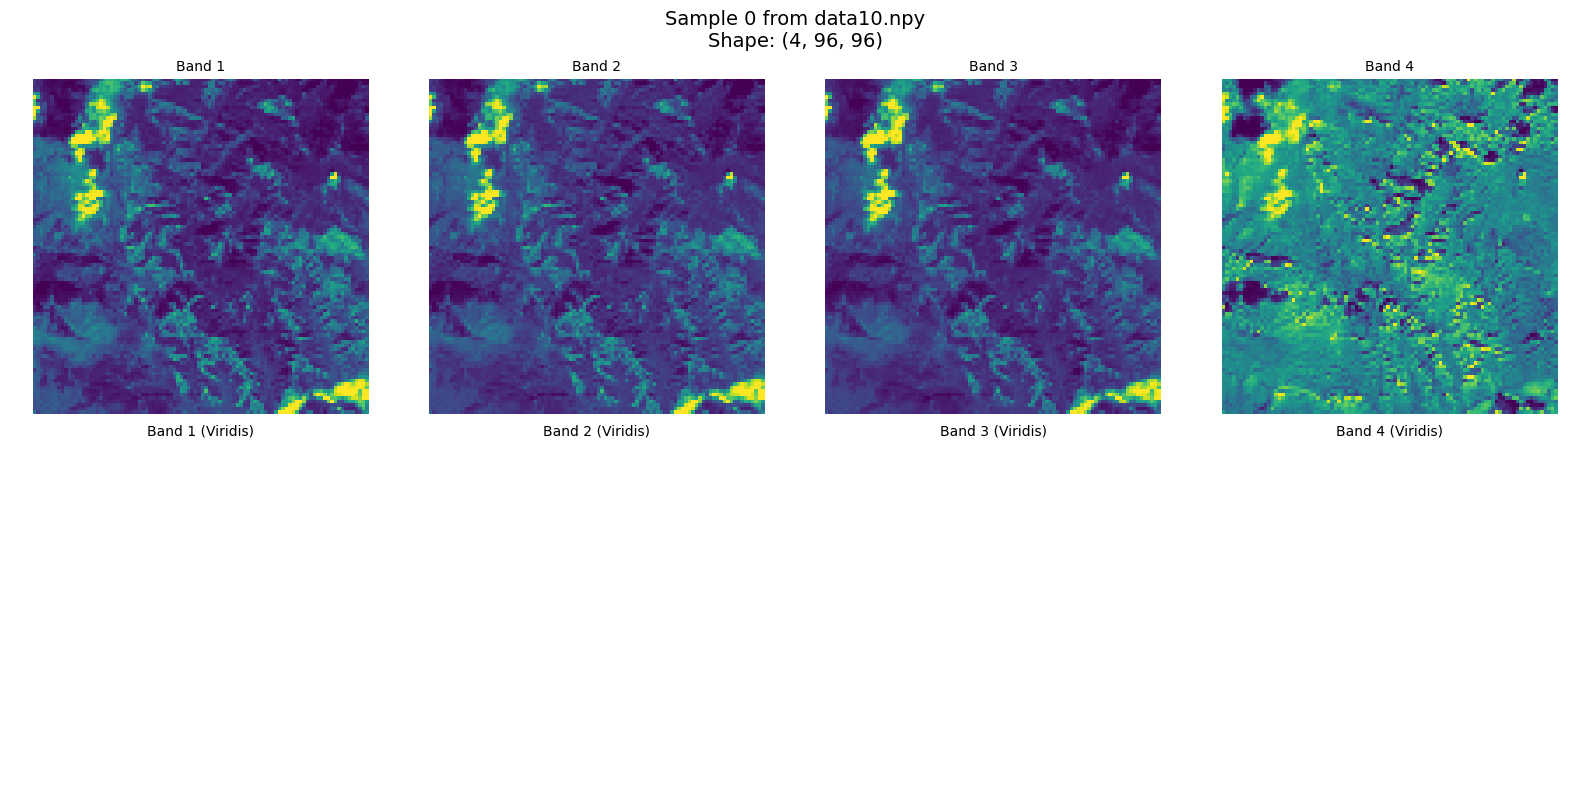


Statistics for sample 0:
Band 1: min=913.14, max=5463.14, mean=1393.07, std=350.06
Band 2: min=887.53, max=5451.39, mean=1357.21, std=310.28
Band 3: min=804.42, max=5609.69, mean=1213.38, std=307.66
Band 4: min=1144.83, max=6318.19, mean=2597.85, std=442.30

Comparing files side by side...
Loaded train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data60_gt.npy: shape (500, 2, 96, 96)
Loaded train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20.npy: shape (500, 6, 96, 96)
Loaded train60/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data10.npy: shape (500, 4, 96, 96)


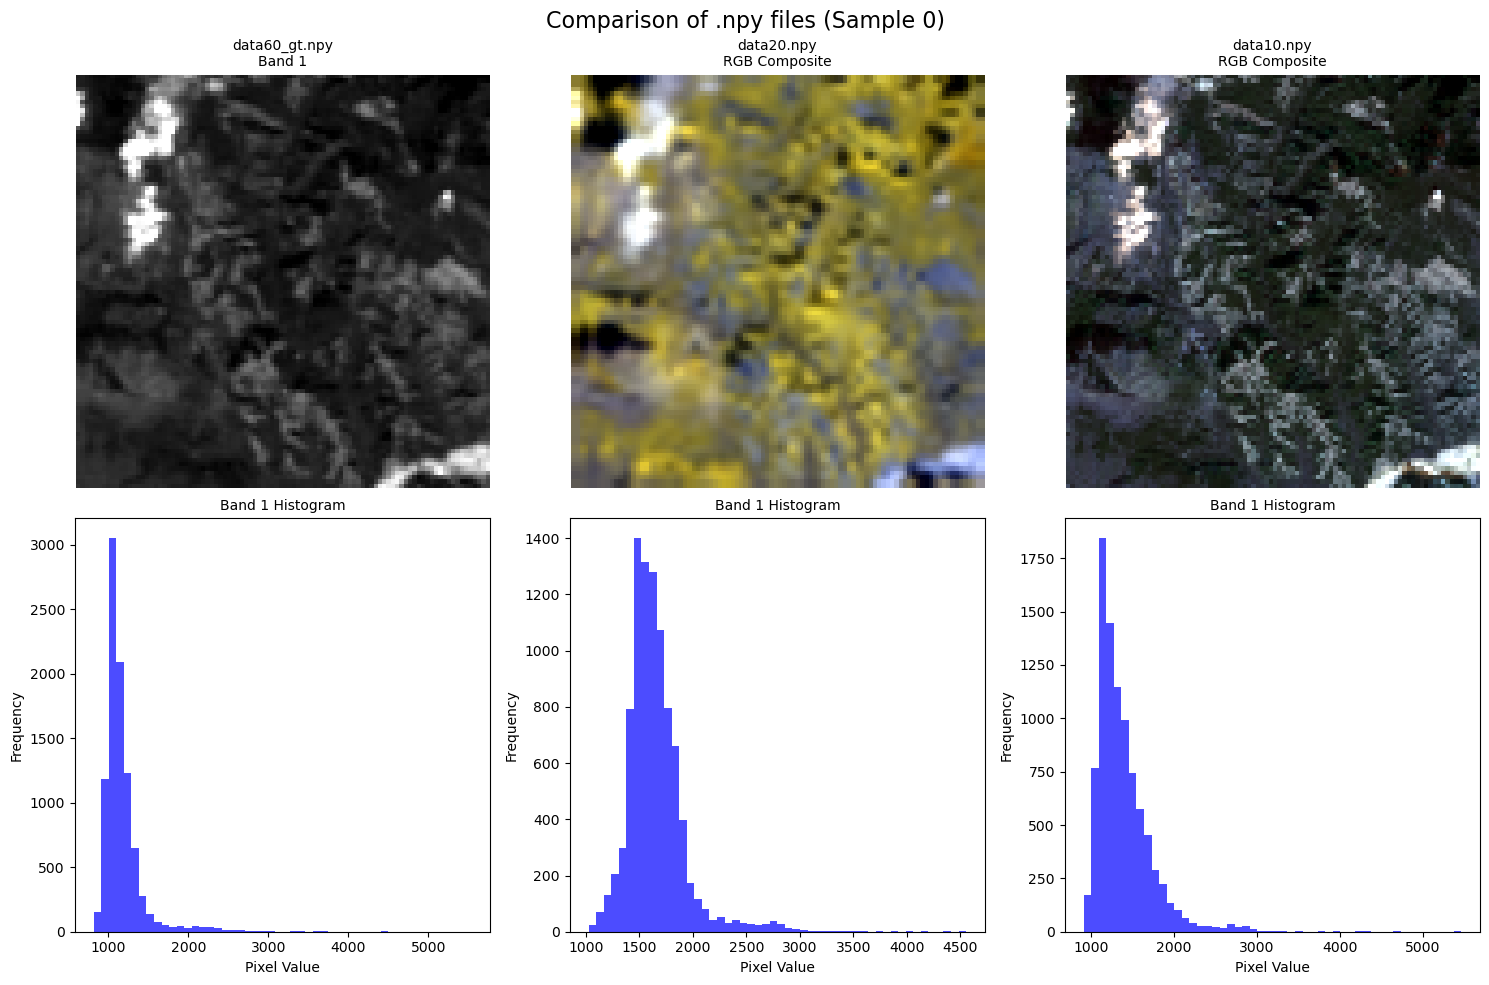

In [13]:


def load_npy_data(filename):
    """Load .npy data with format [number of images, channels, w, h]"""
    try:
        data = np.load(filename)
        print(f"Loaded {filename}: shape {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

def normalize_band(band_data):
    """Normalize image data using percentile clipping"""
    if band_data is None or band_data.size == 0:
        return band_data
    
    # Clip to 1st and 99th percentiles to handle outliers
    p1, p99 = np.percentile(band_data, (1, 99))
    normalized = np.clip(band_data, p1, p99)
    
    # Normalize to [0, 1]
    if p99 > p1:
        normalized = (normalized - p1) / (p99 - p1)
    
    return normalized

def visualize_npy_sample(data, sample_idx=0, filename="", max_bands=6):
    """Visualize a single sample from .npy data"""
    if data is None or len(data.shape) != 4:
        print("Invalid data format. Expected [images, channels, w, h]")
        return
    
    if sample_idx >= data.shape[0]:
        print(f"Sample index {sample_idx} out of range. Data has {data.shape[0]} samples")
        return
    
    sample = data[sample_idx]  # Shape: [channels, w, h]
    num_bands = min(sample.shape[0], max_bands)
    
    # Create subplot grid
    fig, axes = plt.subplots(2, num_bands, figsize=(4*num_bands, 8))
    if num_bands == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle(f'Sample {sample_idx} from {filename}\nShape: {sample.shape}', fontsize=14)
    
    for i in range(num_bands):
        band_data = sample[i]  # Shape: [w, h]
        normalized = normalize_band(band_data)
        
        # Top row: grayscale
        im1 = axes[0, i].imshow(normalized, cmap='gray')
        axes[0, i].set_title(f'Band {i+1}', fontsize=10)
        axes[0, i].axis('off')
        
        # Bottom row: viridis colormap
        im2 = axes[0, i].imshow(normalized, cmap='viridis')
        axes[1, i].set_title(f'Band {i+1} (Viridis)', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistics for sample {sample_idx}:")
    for i in range(num_bands):
        band_data = sample[i]
        print(f"Band {i+1}: min={band_data.min():.2f}, max={band_data.max():.2f}, "
              f"mean={band_data.mean():.2f}, std={band_data.std():.2f}")

def compare_npy_samples(filenames, max_files=3, sample_idx=0):
    """Compare multiple .npy files side by side"""
    if not filenames:
        print("No files provided")
        return
    
    files_to_show = filenames[:max_files]
    num_files = len(files_to_show)
    
    fig, axes = plt.subplots(2, num_files, figsize=(5*num_files, 10))
    if num_files == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle(f'Comparison of .npy files (Sample {sample_idx})', fontsize=16)
    
    for i, filename in enumerate(files_to_show):
        data = load_npy_data(filename)
        if data is not None and sample_idx < data.shape[0]:
            sample = data[sample_idx]
            num_bands = min(sample.shape[0], 3)  # Show first 3 bands
            
            # Create RGB composite if we have at least 3 bands
            if num_bands >= 3:
                height, width = sample.shape[1], sample.shape[2]
                rgb = np.zeros((height, width, 3))
                rgb[:, :, 0] = normalize_band(sample[2])  # Red
                rgb[:, :, 1] = normalize_band(sample[1])  # Green
                rgb[:, :, 2] = normalize_band(sample[0])  # Blue
                
                axes[0, i].imshow(rgb)
                axes[0, i].set_title(f'{os.path.basename(filename)}\nRGB Composite', fontsize=10)
            else:
                # Show first band in grayscale
                normalized = normalize_band(sample[0])
                axes[0, i].imshow(normalized, cmap='gray')
                axes[0, i].set_title(f'{os.path.basename(filename)}\nBand 1', fontsize=10)
            
            axes[0, i].axis('off')
            
            # Show histogram of first band
            if num_bands > 0:
                band_data = sample[0].flatten()
                axes[1, i].hist(band_data, bins=50, alpha=0.7, color='blue')
                axes[1, i].set_title(f'Band 1 Histogram', fontsize=10)
                axes[1, i].set_xlabel('Pixel Value')
                axes[1, i].set_ylabel('Frequency')
        else:
            axes[0, i].text(0.5, 0.5, f'Failed to load\n{os.path.basename(filename)}', 
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Find all .npy files in train60 directory
train60_path = "train60"
if os.path.exists(train60_path):
    npy_files = glob.glob(os.path.join(train60_path, "**/*.npy"), recursive=True)
    print(f"Found {len(npy_files)} .npy files in {train60_path}:")
    for file in npy_files:
        print(f"  - {file}")
    
    # Visualize first few files
    if npy_files:
        print(f"\nVisualizing first {min(3, len(npy_files))} files...")
        for i, file in enumerate(npy_files[:3]):
            print(f"\n{'='*50}")
            print(f"File {i+1}: {file}")
            print('='*50)
            
            data = load_npy_data(file)
            if data is not None:
                visualize_npy_sample(data, sample_idx=0, filename=os.path.basename(file))
        
        # Compare files side by side
        print(f"\n{'='*50}")
        print("Comparing files side by side...")
        print('='*50)
        compare_npy_samples(npy_files[:3], max_files=3, sample_idx=0)
    else:
        print("No .npy files found in train60 directory")
else:
    print(f"Directory {train60_path} not found. Please check the path.")
